In [1]:
!pip install matplotlib seaborn plotly pandas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from google.colab import auth
from google.cloud import bigquery

In [3]:
auth.authenticate_user()
client = bigquery.Client("projecto-riesgo-relativo")

In [4]:
query = """
SELECT user_id, age, last_month_salary, number_dependents,default_flag, more_90_days_overdue, using_lines_not_secured_personal_assets,number_times_delayed_payment_loan_30_59_days,debt_ratio,number_times_delayed_payment_loan_60_89_days
FROM `projecto-riesgo-relativo.Dataset.view_consolidado`
"""

In [5]:
df = client.query(query).to_dataframe()

In [6]:
df.head()


,user_id,age,last_month_salary,number_dependents,default_flag,more_90_days_overdue,using_lines_not_secured_personal_assets,number_times_delayed_payment_loan_30_59_days,debt_ratio,number_times_delayed_payment_loan_60_89_days
0,1,55,2200.0,0,0,0,0.667083,0,0.153112,0
1,2,44,7499.0,0,0,0,0.007093,0,0.148800,0
2,3,54,5900.0,0,0,0,0.091213,0,0.351635,1
3,4,54,2167.0,0,0,0,0.112680,0,0.065959,0
4,5,42,10415.0,2,0,0,0.323985,0,0.352151,0


Medidas de Tendencia central Age

In [7]:
df['age'].describe()

,age
count,35558.0
mean,52.52112
std,14.720023
min,21.0
25%,42.0
50%,52.0
75%,63.0
max,96.0


In [8]:
df['using_lines_not_secured_personal_assets'].describe()

,using_lines_not_secured_personal_assets
count,35558.000000
mean,5.867188
std,224.790758
min,0.000000
25%,0.028849
50%,0.144425
75%,0.529473
max,22000.000000


In [9]:
unique_ages_sorted = sorted(df['age'].unique())
print("Valores únicos de la columna 'age':", unique_ages_sorted)

Valores únicos de la columna 'age': [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]


In [10]:
# Definir los límites y etiquetas para las generaciones
bins = [0, 12, 28, 44, 60, 79, 111,123]
labels = ['Generación Alpha', 'Generación Z (Centennials)', 'Generación Y (Millennials)', 'Generación X', 'Baby Boomers', 'Silent Generation', 'Otro']

# Crear una nueva columna 'generation' con las categorías de edad
df['generation'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Contar el número de personas en cada generación
generation_counts = df['generation'].value_counts().sort_index()

# Crear un gráfico de barras usando Plotly
fig = px.bar(generation_counts, x=generation_counts.index, y=generation_counts.values,
             labels={'x': 'Generación', 'y': 'Número de Personas'},
             title='Distribución de Edades por Generación')

# Mostrar el gráfico
fig.show()

In [11]:
# Calcular el porcentaje de pago y no pago por generación
generation_payment = df.groupby(['generation', 'default_flag']).size().reset_index(name='counts')
generation_totals = df.groupby(['generation']).size().reset_index(name='totals')
generation_payment = pd.merge(generation_payment, generation_totals, on='generation')
generation_payment['percentage'] = generation_payment['counts'] / generation_payment['totals'] * 100

# Crear un gráfico de barras apiladas usando Plotly
fig = px.bar(generation_payment,
             x='generation',
             y='percentage',
             color='default_flag',
             barmode='stack',
             labels={'generation': 'Generación', 'percentage': 'Porcentaje', 'default_flag': 'Estado de Pago'},
             title='Porcentaje de Pago y No Pago por Generación')

# Mostrar el gráfico
fig.show()

# Mostrar el DataFrame con los cálculos
print(generation_payment)

<ipython-input-11-fb1a5323fef1>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-11-fb1a5323fef1>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



                    generation  default_flag  counts  totals  percentage
0             Generación Alpha             0       0       0         NaN
1             Generación Alpha             1       0       0         NaN
2   Generación Z (Centennials)             0    1208    1237   97.655618
3   Generación Z (Centennials)             1      29    1237    2.344382
4   Generación Y (Millennials)             0    8778    9057   96.919510
5   Generación Y (Millennials)             1     279    9057    3.080490
6                 Generación X             0   13389   13631   98.224635
7                 Generación X             1     242   13631    1.775365
8                 Baby Boomers             0    9903    9968   99.347913
9                 Baby Boomers             1      65    9968    0.652087
10           Silent Generation             0    1659    1665   99.639640
11           Silent Generation             1       6    1665    0.360360
12                        Otro             0       

Calculo de la mediana para using_lines_not_secured_personal_assets

In [12]:
import pandas as pd
import plotly.express as px

# Agrupar los datos por generación y calcular la media del ratio de utilización de crédito
generation_credit_utilization = df.groupby('generation')['using_lines_not_secured_personal_assets'].mean().reset_index()

# Renombrar la columna para mayor claridad
generation_credit_utilization = generation_credit_utilization.rename(columns={'using_lines_not_secured_personal_assets': 'average_credit_utilization'})

# Convertir la media del ratio de utilización de crédito a porcentaje
generation_credit_utilization['average_credit_utilization'] = generation_credit_utilization['average_credit_utilization'] * 100

# Crear un gráfico de barras usando Plotly
fig = px.bar(generation_credit_utilization,
             x='generation',
             y='average_credit_utilization',
             labels={'generation': 'Generación', 'average_credit_utilization': 'Porcentaje de Utilización de Crédito'},
             title='Porcentaje de Utilización de Crédito por Generación')

# Mostrar el gráfico
fig.show()

# Mostrar el DataFrame con los cálculos
print(generation_credit_utilization)



<ipython-input-12-5e6a7b92b3e0>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



                   generation  average_credit_utilization
0            Generación Alpha                         NaN
1  Generación Z (Centennials)                  549.974905
2  Generación Y (Millennials)                  870.069735
3                Generación X                  599.622207
4                Baby Boomers                  412.293871
5           Silent Generation                   11.298294
6                        Otro                         NaN


Identificar Outliers usando método del rango intercuartil (IQR)

In [13]:
#DataFrame df con una columna llamada 'edad'
edad = df['age']
# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1 = edad.quantile(0.25)
Q3 = edad.quantile(0.75)
# Calcular el IQR
IQR = Q3 - Q1
print(f"El primer cuartil (Q1) es: {Q1}")
print(f"El tercer cuartil (Q3) es: {Q3}")
print(f"El rango intercuartil (IQR) es: {IQR}")

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identificar los outliers
outliers = edad[(edad < lower_bound)|(edad > upper_bound)]
print(f"El límite inferior para los outliers es: {lower_bound}")
print(f"El límite superior para los outliers es: {upper_bound}")
print(f"Los outliers son: \n{outliers}")

El primer cuartil (Q1) es: 42.0
El tercer cuartil (Q3) es: 63.0
El rango intercuartil (IQR) es: 21.0
El límite inferior para los outliers es: 10.5
El límite superior para los outliers es: 94.5
Los outliers son: 
3213     95
4343     96
6644     95
8223     95
12330    95
13122    95
16690    96
16942    95
22003    95
22902    95
23002    96
24813    96
25621    95
30496    95
33804    95
34465    96
35393    96
Name: age, dtype: Int64


BoxPlot Interactivo para Age

In [14]:
import plotly.express as px
import pandas as pd
# Crear un boxplot interactivo usando Plotly
fig = px.box(df, y='age', points="all", title="Age")
# Mostrar el gráfico
fig.show()

Histograma para la variable Age

In [15]:
import pandas as pd
import plotly.express as px
# Supongamos que ya tienes un DataFrame df con una columna llamada 'edad'
edad = df['age']
# Crear el histograma interactivo
fig = px.histogram(edad, x='age', title='Histograma Age')
# Mostrar el histograma interactivo
fig.show()

Medidas de tendencia central y dispersión para last_month_salary

In [16]:
df['last_month_salary'].describe()

,last_month_salary
count,35558.00000
mean,6592.34264
std,5292.00092
min,0.00000
25%,3947.25000
50%,6600.00000
75%,7493.25000
max,150000.00000


Identificar Outliers last_month_salary usando método del rango intercuartil (IQR)

In [17]:
# DataFrame df 'last_month_salary'
salary = df['last_month_salary']

# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1_salary = salary.quantile(0.25)
Q3_salary = salary.quantile(0.75)

# Calcular el IQR
IQR_salary = Q3_salary - Q1_salary
print(f"El primer cuartil (Q1) de last_month_salary es: {Q1_salary}")
print(f"El tercer cuartil (Q3) de last_month_salary es: {Q3_salary}")
print(f"El rango intercuartil (IQR) de last_month_salary es: {IQR_salary}")

# Definir los límites para los outliers
lower_bound_salary = Q1_salary - 1.5 * IQR_salary
upper_bound_salary = Q3_salary + 1.5 * IQR_salary

# Identificar los outliers
outliers_salary = salary[(salary < lower_bound_salary) | (salary > upper_bound_salary)]
print(f"El límite inferior para los outliers de last_month_salary es: {lower_bound_salary}")
print(f"El límite superior para los outliers de last_month_salary es: {upper_bound_salary}")
print(f"Los outliers de last_month_salary son: \n{outliers_salary}")

El primer cuartil (Q1) de last_month_salary es: 3947.25
El tercer cuartil (Q3) de last_month_salary es: 7493.25
El rango intercuartil (IQR) de last_month_salary es: 3546.0
El límite inferior para los outliers de last_month_salary es: -1371.75
El límite superior para los outliers de last_month_salary es: 12812.25
Los outliers de last_month_salary son: 
7        15658.0
61       15000.0
85       51140.0
102      13455.0
104      12996.0
          ...   
35457    14574.0
35466    12887.0
35487    19000.0
35496    21600.0
35506    15125.0
Name: last_month_salary, Length: 2126, dtype: float64


BoxPlot last_month_salary

In [18]:
import plotly.express as px

# Crear un boxplot interactivo usando Plotly para last_month_salary
fig = px.box(df, y='last_month_salary', points="all", title="Boxplot de Last Month Salary")
fig.show()

Identificar Outliers usando método del rango intercuartil (IQR)

In [19]:
#DataFrame df 'number_dependents'
dependents = df['number_dependents']
# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1 = dependents.quantile(0.25)
Q3 = dependents.quantile(0.75)
# Calcular el IQR
IQR = Q3 - Q1
print(f"El primer cuartil (Q1) es: {Q1}")
print(f"El tercer cuartil (Q3) es: {Q3}")
print(f"El rango intercuartil (IQR) es: {IQR}")

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identificar los outliers
outliers = dependents[(dependents < lower_bound)|(dependents > upper_bound)]
print(f"El límite inferior para los outliers es: {lower_bound}")
print(f"El límite superior para los outliers es: {upper_bound}")
print(f"Los outliers son: \n{outliers}")

El primer cuartil (Q1) es: 0.0
El tercer cuartil (Q3) es: 1.0
El rango intercuartil (IQR) es: 1.0
El límite inferior para los outliers es: -1.5
El límite superior para los outliers es: 2.5
Los outliers son: 
41       4
65       3
81       3
82       3
85       3
        ..
35503    3
35509    4
35513    3
35519    3
35527    4
Name: number_dependents, Length: 3207, dtype: Int64


BoxPlot Numero de dependientes

In [20]:
import plotly.express as px
import pandas as pd

# Crear un boxplot interactivo usando Plotly para number_dependents
fig = px.box(df, y='number_dependents', points="all", title="Number Dependents")
# Mostrar el gráfico
fig.show()

Histograma

In [21]:
import pandas as pd
import plotly.express as px
# DataFrame df 'number_dependents'
dependents = df['number_dependents']
# Crear el histograma interactivo
fig = px.histogram(dependents, x='number_dependents', title='Histograma Number dependents')
# Mostrar el histograma interactivo
fig.show()

In [22]:
#Medidas de tendencia central y dispersión para more_90_days_overdue
df['more_90_days_overdue'].describe()

,more_90_days_overdue
count,35558.0
mean,0.085803
std,0.492347
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,15.0


In [23]:
#OUTLIERS
#DataFrame df 'more_90_days_overdue'
ninety = df['more_90_days_overdue']
# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1 = ninety.quantile(0.25)
Q3 = ninety.quantile(0.75)
# Calcular el IQR
IQR = Q3 - Q1
print(f"El primer cuartil (Q1) es: {Q1}")
print(f"El tercer cuartil (Q3) es: {Q3}")
print(f"El rango intercuartil (IQR) es: {IQR}")

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identificar los outliers
outliers = ninety[(ninety < lower_bound)|(ninety > upper_bound)]
print(f"El límite inferior para los outliers es: {lower_bound}")
print(f"El límite superior para los outliers es: {upper_bound}")
print(f"Los outliers son: \n{outliers}")

El primer cuartil (Q1) es: 0.0
El tercer cuartil (Q3) es: 0.0
El rango intercuartil (IQR) es: 0.0
El límite inferior para los outliers es: 0.0
El límite superior para los outliers es: 0.0
Los outliers son: 
7        1
13       1
22       5
28       1
85       2
        ..
35431    1
35472    3
35507    1
35536    2
35554    1
Name: more_90_days_overdue, Length: 1774, dtype: Int64


In [24]:
import plotly.express as px
import pandas as pd

# Crear un boxplot interactivo usando Plotly para more_90_days_overdue
fig = px.box(df, y='more_90_days_overdue', points="all", title="more_90_days_overdue")
# Mostrar el gráfico
fig.show()

In [25]:
import pandas as pd
import plotly.express as px
# DataFrame df 'more_90_days_overdue'
dependents = df['more_90_days_overdue']
# Crear el histograma interactivo
fig = px.histogram(dependents, x='more_90_days_overdue', title='Histograma more_90_days_overdue')
# Mostrar el histograma interactivo
fig.show()

In [26]:
#Medidas de tendencia central y dispersión para using_lines_not_secured_personal_assets
df['using_lines_not_secured_personal_assets'].describe()

,using_lines_not_secured_personal_assets
count,35558.000000
mean,5.867188
std,224.790758
min,0.000000
25%,0.028849
50%,0.144425
75%,0.529473
max,22000.000000


In [27]:
#OUTLIERS
#DataFrame df 'using_lines_not_secured_personal_assets'
lines = df['using_lines_not_secured_personal_assets']
# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1 = lines.quantile(0.25)
Q3 = lines.quantile(0.75)
# Calcular el IQR
IQR = Q3 - Q1
print(f"El primer cuartil (Q1) es: {Q1}")
print(f"El tercer cuartil (Q3) es: {Q3}")
print(f"El rango intercuartil (IQR) es: {IQR}")

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identificar los outliers
outliers = lines[(lines < lower_bound)|(lines > upper_bound)]
print(f"El límite inferior para los outliers es: {lower_bound}")
print(f"El límite superior para los outliers es: {upper_bound}")
print(f"Los outliers son: \n{outliers}")

El primer cuartil (Q1) es: 0.028849408
El tercer cuartil (Q3) es: 0.52947285775
El rango intercuartil (IQR) es: 0.50062344975
El límite inferior para los outliers es: -0.7220857666249999
El límite superior para los outliers es: 1.280408032375
Los outliers son: 
386      5186.000000
495       112.000000
708         1.465534
770         4.638723
1355        1.591362
            ...     
34466      18.000000
34476    1819.000000
34550       1.299003
34651    2376.000000
35489       1.588741
Name: using_lines_not_secured_personal_assets, Length: 194, dtype: float64


In [28]:
import plotly.express as px
import pandas as pd

# Crear un boxplot interactivo usando Plotly para using_lines_not_secured_personal_assets
fig = px.box(df, y='using_lines_not_secured_personal_assets', points="all", title="using_lines_not_secured_personal_assets")
# Mostrar el gráfico
fig.show()

In [29]:
import pandas as pd
import plotly.express as px
# DataFrame df 'using_lines_not_secured_personal_assets'
dependents = df['using_lines_not_secured_personal_assets']
# Crear el histograma interactivo
fig = px.histogram(dependents, x='using_lines_not_secured_personal_assets', title='Histograma using_lines_not_secured_personal_assets')
# Mostrar el histograma interactivo
fig.show()

In [30]:
#Medidas de tendencia central y dispersión para number_times_delayed_payment_loan_30_59_days
df['number_times_delayed_payment_loan_30_59_days'].describe()

,number_times_delayed_payment_loan_30_59_days
count,35558.0
mean,0.249705
std,0.703466
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,11.0


In [31]:
#OUTLIERS
#DataFrame df 'number_times_delayed_payment_loan_30_59_days'
thirty = df['number_times_delayed_payment_loan_30_59_days']
# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1 = thirty.quantile(0.25)
Q3 = thirty.quantile(0.75)
# Calcular el IQR
IQR = Q3 - Q1
print(f"El primer cuartil (Q1) es: {Q1}")
print(f"El tercer cuartil (Q3) es: {Q3}")
print(f"El rango intercuartil (IQR) es: {IQR}")

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identificar los outliers
outliers = thirty[(thirty < lower_bound)|(thirty > upper_bound)]
print(f"El límite inferior para los outliers es: {lower_bound}")
print(f"El límite superior para los outliers es: {upper_bound}")
print(f"Los outliers son: \n{outliers}")

El primer cuartil (Q1) es: 0.0
El tercer cuartil (Q3) es: 0.0
El rango intercuartil (IQR) es: 0.0
El límite inferior para los outliers es: 0.0
El límite superior para los outliers es: 0.0
Los outliers son: 
6        1
8        1
10       1
14       1
28       4
        ..
35539    1
35542    1
35544    1
35554    1
35557    2
Name: number_times_delayed_payment_loan_30_59_days, Length: 5712, dtype: Int64


In [32]:
import plotly.express as px
import pandas as pd

# Crear un boxplot interactivo usando Plotly para number_times_delayed_payment_loan_30_59_days
fig = px.box(df, y='number_times_delayed_payment_loan_30_59_days', points="all", title="number_times_delayed_payment_loan_30_59_days")
# Mostrar el gráfico
fig.show()

In [33]:
import pandas as pd
import plotly.express as px
# DataFrame df 'number_times_delayed_payment_loan_30_59_days'
dependents = df['number_times_delayed_payment_loan_30_59_days']
# Crear el histograma interactivo
fig = px.histogram(dependents, x='number_times_delayed_payment_loan_30_59_days', title='Histograma number_times_delayed_payment_loan_30_59_days')
# Mostrar el histograma interactivo
fig.show()

In [34]:
#Medidas de tendencia central y dispersión para debt_ratio
df['debt_ratio'].describe()

,debt_ratio
count,35558.000000
mean,347.065397
std,1204.532781
min,0.000000
25%,0.181304
50%,0.369340
75%,0.881342
max,60212.000000


In [35]:
#OUTLIERS
#DataFrame df 'debt_ratio'
ratio = df['debt_ratio']
# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1 = ratio.quantile(0.25)
Q3 = ratio.quantile(0.75)
# Calcular el IQR
IQR = Q3 - Q1
print(f"El primer cuartil (Q1) es: {Q1}")
print(f"El tercer cuartil (Q3) es: {Q3}")
print(f"El rango intercuartil (IQR) es: {IQR}")

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identificar los outliers
outliers = ratio[(ratio < lower_bound)|(ratio > upper_bound)]
print(f"El límite inferior para los outliers es: {lower_bound}")
print(f"El límite superior para los outliers es: {upper_bound}")
print(f"Los outliers son: \n{outliers}")

El primer cuartil (Q1) es: 0.1813043445
El tercer cuartil (Q3) es: 0.8813419485
El rango intercuartil (IQR) es: 0.700037604
El límite inferior para los outliers es: -0.8687520615
El límite superior para los outliers es: 1.9313983545
Los outliers son: 
9          11.41791
11        859.00000
18       2610.00000
19       1546.00000
21       1477.00000
            ...    
35540     927.00000
35541    2055.00000
35544    1333.00000
35546       7.00000
35548     121.00000
Name: debt_ratio, Length: 7497, dtype: float64


In [36]:
import plotly.express as px
import pandas as pd

# Crear un boxplot interactivo usando Plotly para debt_ratio
fig = px.box(df, y='debt_ratio', points="all", title="debt_ratio")
# Mostrar el gráfico
fig.show()

In [37]:
import pandas as pd
import plotly.express as px
# DataFrame df 'debt_ratio'
ratio = df['debt_ratio']
# Crear el histograma interactivo
fig = px.histogram(ratio, x='debt_ratio', title='Histograma debt_ratio')
# Mostrar el histograma interactivo
fig.show()

In [38]:
#Medidas de tendencia central y dispersión para number_times_delayed_payment_loan_60_89_days
df['number_times_delayed_payment_loan_60_89_days'].describe()

,number_times_delayed_payment_loan_60_89_days
count,35558.0
mean,0.066399
std,0.333395
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,7.0


In [39]:
#OUTLIERS
#DataFrame df 'number_times_delayed_payment_loan_60_89_days'
sixty = df['number_times_delayed_payment_loan_60_89_days']
# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1 = sixty.quantile(0.25)
Q3 = sixty.quantile(0.75)
# Calcular el IQR
IQR = Q3 - Q1
print(f"El primer cuartil (Q1) es: {Q1}")
print(f"El tercer cuartil (Q3) es: {Q3}")
print(f"El rango intercuartil (IQR) es: {IQR}")

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identificar los outliers
outliers = ratio[(sixty < lower_bound)|(sixty > upper_bound)]
print(f"El límite inferior para los outliers es: {lower_bound}")
print(f"El límite superior para los outliers es: {upper_bound}")
print(f"Los outliers son: \n{outliers}")

El primer cuartil (Q1) es: 0.0
El tercer cuartil (Q3) es: 0.0
El rango intercuartil (IQR) es: 0.0
El límite inferior para los outliers es: 0.0
El límite superior para los outliers es: 0.0
Los outliers son: 
2          0.351635
28         0.492458
40         0.817720
147        0.075084
151        0.299350
            ...    
35471      0.277842
35472      0.576529
35504      0.115534
35542      0.130724
35548    121.000000
Name: debt_ratio, Length: 1775, dtype: float64


In [40]:
import plotly.express as px
import pandas as pd

# Crear un boxplot interactivo usando Plotly para number_times_delayed_payment_loan_60_89_days
fig = px.box(df, y='number_times_delayed_payment_loan_60_89_days', points="all", title="number_times_delayed_payment_loan_60_89_days")
# Mostrar el gráfico
fig.show()

In [41]:
import pandas as pd
import plotly.express as px
# DataFrame df 'number_times_delayed_payment_loan_60_89_days'
dependents = df['number_times_delayed_payment_loan_60_89_days']
# Crear el histograma interactivo
fig = px.histogram(dependents, x='number_times_delayed_payment_loan_60_89_days', title='Histograma number_times_delayed_payment_loan_60_89_days')
# Mostrar el histograma interactivo
fig.show()

In [42]:
import pandas as pd
import plotly.express as px

fig = px.box(df,
             x='default_flag',         # Variable categórica para el eje X
             y='last_month_salary',    # Variable numérica para el eje Y
             title='Distribución de Salario del Último Mes por Flag de Default',
             labels={'default_flag': 'Flag de Default', 'last_month_salary': 'Salario del Último Mes'},
             color='default_flag',      # Color por la variable categórica
             category_orders={'default_flag': [0, 1]}  # Ordenar las categorías si es necesario
            )

# Personalizar la apariencia
fig.update_layout(
    xaxis_title='Flag de Default',
    yaxis_title='Salario del Último Mes',
    boxmode='group'  # Agrupar los boxplots para comparación
)

# Mostrar el gráfico
fig.show()

In [43]:
query = """
SELECT user_id, age, last_month_salary, number_dependents,default_flag, more_90_days_overdue, using_lines_not_secured_personal_assets,number_times_delayed_payment_loan_30_59_days,debt_ratio,number_times_delayed_payment_loan_60_89_days
FROM `projecto-riesgo-relativo.Dataset.view_consolidado`
"""

In [44]:
df = pd.read_gbq(query, project_id='projecto-riesgo-relativo')

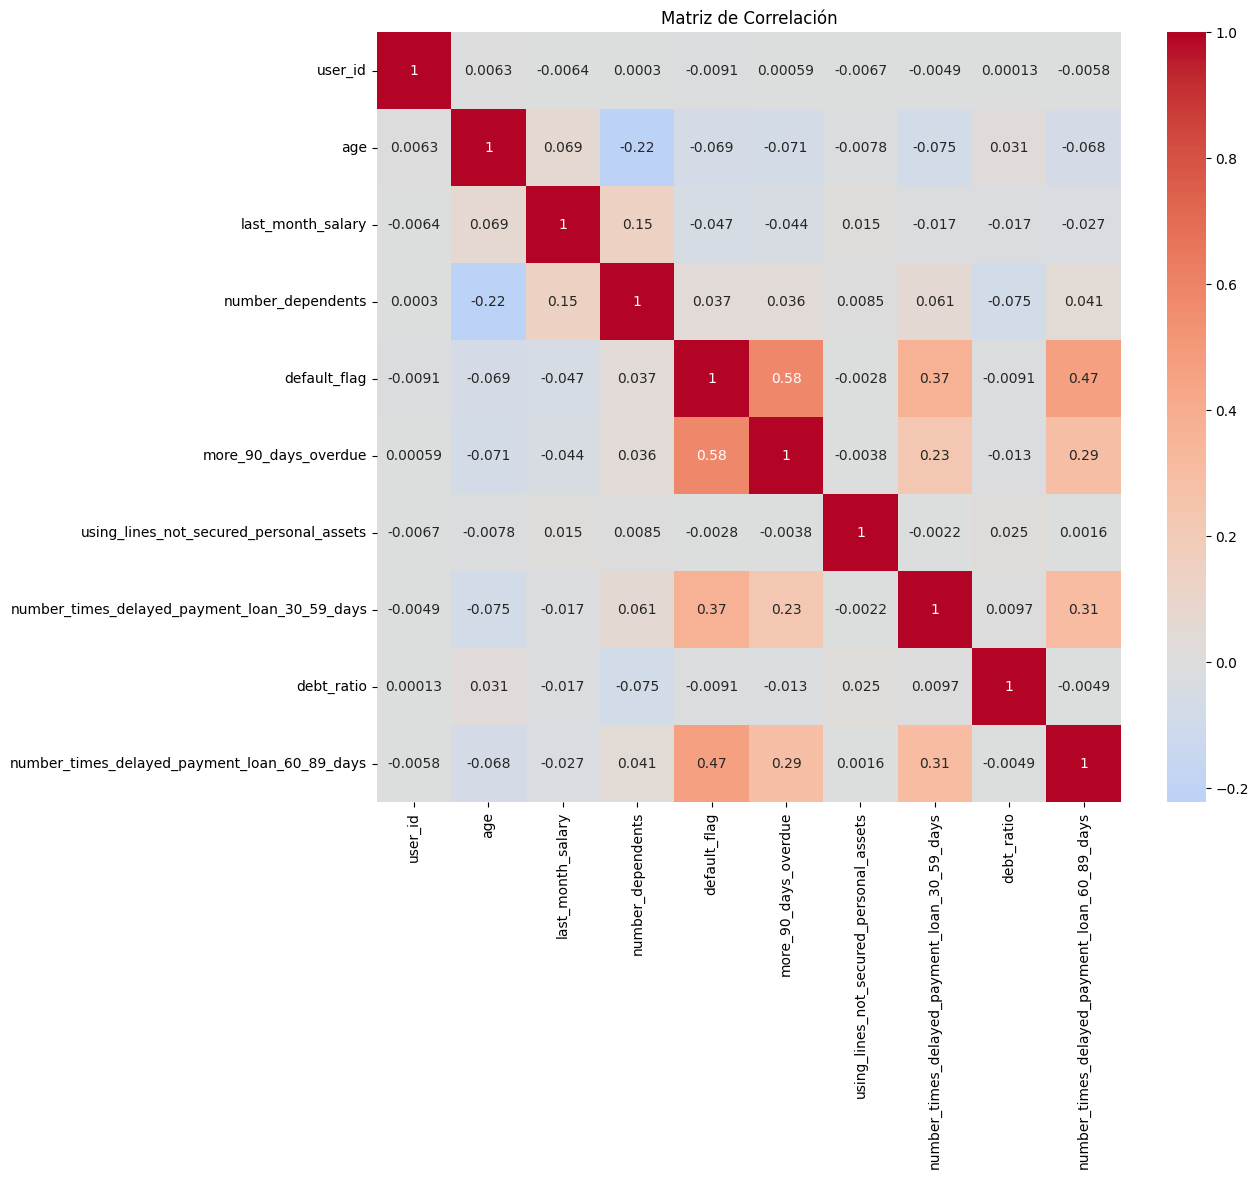

In [45]:
correlation_matrix = df.corr()

# Crear el gráfico de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from google.colab import auth
from google.cloud import bigquery

In [47]:
auth.authenticate_user()
client = bigquery.Client("projecto-riesgo-relativo")

In [48]:
project_id = "projecto-riesgo-relativo"
dataset = "Dataset"
table = "Tabla_score"

In [49]:
query = """
SELECT user_id, age, total_loans, more_90_days_overdue, debt_ratio, using_lines_not_secured_personal_assets, last_month_salary, number_dependents, default_flag, clasificacion, suma_puntaje
FROM `projecto-riesgo-relativo.Dataset.Tabla_score`
"""

In [50]:
df = client.query(query).to_dataframe()
df.head()

,user_id,age,total_loans,more_90_days_overdue,debt_ratio,using_lines_not_secured_personal_assets,last_month_salary,number_dependents,default_flag,clasificacion,suma_puntaje
0,2303,21,1,0,672,1,6715,0,0,Mal pagador,4
1,2932,21,1,0,9,0,6715,0,0,Buen pagador,3
2,3985,21,1,0,0,0,3300,0,0,Mal pagador,4
3,4732,21,1,0,0,1,550,0,0,Mal pagador,5
4,8870,21,1,0,0,1,6715,0,0,Mal pagador,4


##Hito 2

Matriz de Confusion


Matriz de Confusión:
[[26107  8830]
 [   58   563]]
Reporte de Clasificación:
              precision    recall  f1-score   support

Buen Pagador       1.00      0.75      0.85     34937
 Mal Pagador       0.06      0.91      0.11       621

    accuracy                           0.75     35558
   macro avg       0.53      0.83      0.48     35558
weighted avg       0.98      0.75      0.84     35558



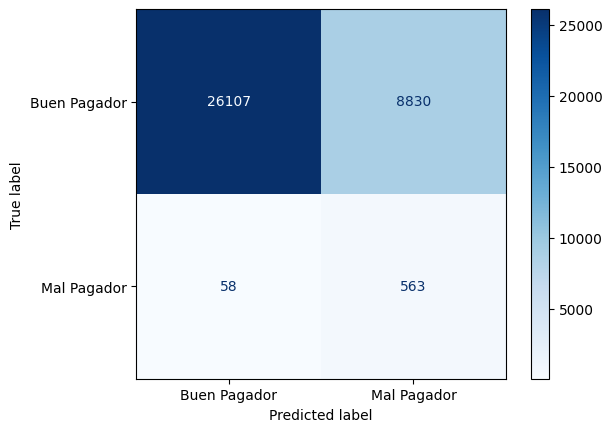

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Convertir las etiquetas de clasificación a valores numéricos
df['clasificacion_encoded'] = df['clasificacion'].map({'Buen pagador': 0, 'Mal pagador': 1})

# Calcular la matriz de confusión
y_true = df['default_flag']
y_pred = df['clasificacion_encoded']

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Imprimir la matriz de confusión
print('Matriz de Confusión:')
print(cm)

# Calcular y mostrar el reporte de clasificación
report = classification_report(y_true, y_pred, labels=[0, 1], target_names=['Buen Pagador', 'Mal Pagador'])
print('Reporte de Clasificación:')
print(report)

# Crear y mostrar la matriz de confusión gráficamente
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buen Pagador', 'Mal Pagador'])
cm_display.plot(cmap=plt.cm.Blues)

# Mostrar el gráfico
plt.show()

##HITO3
Regresion Logistica last_month_salary

In [52]:
# Regresion Logica last_month_salary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [53]:
#definiendo input y output
df['clasificacion_encoded'] = df['clasificacion'].map({'Buen pagador': 0, 'Mal pagador': 1})
X = df[['last_month_salary']]  # Puedes cambiar a otra variable como 'edad', 'debt_ratio', etc.
y = df['clasificacion_encoded']

X_train = np.array(df['last_month_salary']).reshape(-1, 1)
y_train = np.array(df['clasificacion_encoded'])


In [54]:
# Crear el modelo de regresión logística
model = LogisticRegression()
# Entrenar el modelo
model.fit(X_train, y_train)

LogisticRegression()

In [55]:
#Imprimiendo parametros
print(f"Intercepto (b): {model.intercept_}")
print(f"Intercepto (w): {model.coef_}")

Intercepto (b): [8.91667241e-09]
Intercepto (w): [[-0.00020094]]


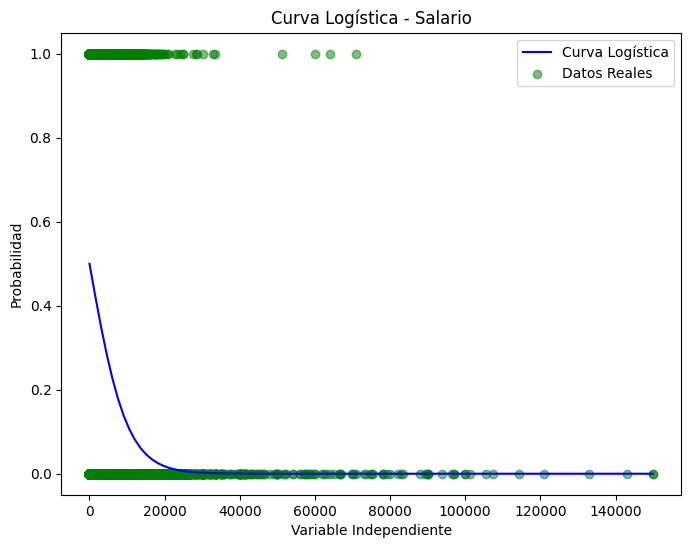

In [56]:
# Crear un rango de valores para la variable independiente
x_values = np.linspace(X.min(), X.max(), 100)

# Calcular las probabilidades predichas
y_prob = model.predict_proba(x_values)[:, 1]

# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar la curva logística
ax.plot(x_values, y_prob, label='Curva Logística', color='blue')

# Graficar los puntos de datos
ax.scatter(X, y, label='Datos Reales', color='green', alpha=0.5)

# Personalizar el gráfico
ax.set_xlabel('Variable Independiente')
ax.set_ylabel('Probabilidad')
ax.set_title('Curva Logística - Salario')
ax.legend()

plt.show()


Matriz de Confusión:
[[25922   243]
 [ 9267   126]]
Reporte de Clasificación:
              precision    recall  f1-score   support

Buen Pagador       0.74      0.99      0.84     26165
 Mal Pagador       0.34      0.01      0.03      9393

    accuracy                           0.73     35558
   macro avg       0.54      0.50      0.44     35558
weighted avg       0.63      0.73      0.63     35558



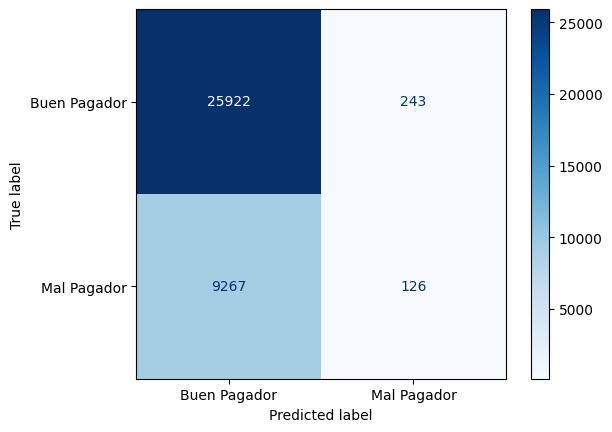

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Usar el modelo entrenado para predecir en los datos de entrenamiento
y_pred = model.predict(X_train)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred, labels=[0, 1])

# Imprimir la matriz de confusión
print('Matriz de Confusión:')
print(cm)

# Calcular y mostrar el reporte de clasificación
report = classification_report(y_train, y_pred, labels=[0, 1], target_names=['Buen Pagador', 'Mal Pagador'])
print('Reporte de Clasificación:')
print(report)

# Crear y mostrar la matriz de confusión gráficamente
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buen Pagador', 'Mal Pagador'])
cm_display.plot(cmap=plt.cm.Blues)

# Mostrar el gráfico
plt.show()


Regresion logica edad

In [58]:
#Regresion logica edad
#definiendo input y output
df['clasificacion_encoded'] = df['clasificacion'].map({'Buen pagador': 0, 'Mal pagador': 1})
X = df[['age']]  # Puedes cambiar a otra variable como 'edad', 'debt_ratio', etc.
y = df['clasificacion_encoded']

X_train = np.array(df['age']).reshape(-1, 1)
y_train = np.array(df['clasificacion_encoded'])



In [59]:
# Crear el modelo de regresión logística
model = LogisticRegression()
# Entrenar el modelo
model.fit(X_train, y_train)

LogisticRegression()

In [60]:
#Imprimiendo parametros
print(f"Intercepto (b): {model.intercept_}")
print(f"Intercepto (w): {model.coef_}")

Intercepto (b): [3.25690822]
Intercepto (w): [[-0.08802345]]


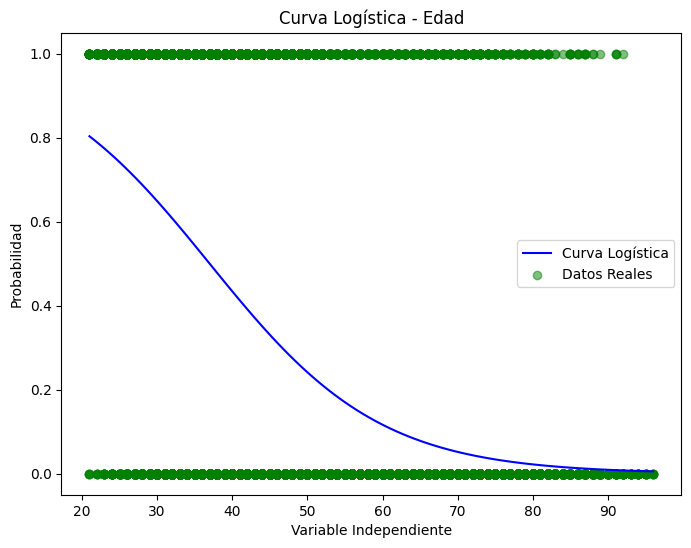

In [61]:
# Crear un rango de valores para la variable independiente
x_values = np.linspace(X.min(), X.max(), 100)

# Calcular las probabilidades predichas
y_prob = model.predict_proba(x_values)[:, 1]

# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar la curva logística
ax.plot(x_values, y_prob, label='Curva Logística', color='blue')

# Graficar los puntos de datos
ax.scatter(X, y, label='Datos Reales', color='green', alpha=0.5)

# Personalizar el gráfico
ax.set_xlabel('Variable Independiente')
ax.set_ylabel('Probabilidad')
ax.set_title('Curva Logística - Edad')
ax.legend()

plt.show()

Matriz de Confusión - Edad:
[[23632  2533]
 [ 5852  3541]]
Reporte de Clasificación:
              precision    recall  f1-score   support

Buen Pagador       0.80      0.90      0.85     26165
 Mal Pagador       0.58      0.38      0.46      9393

    accuracy                           0.76     35558
   macro avg       0.69      0.64      0.65     35558
weighted avg       0.74      0.76      0.75     35558



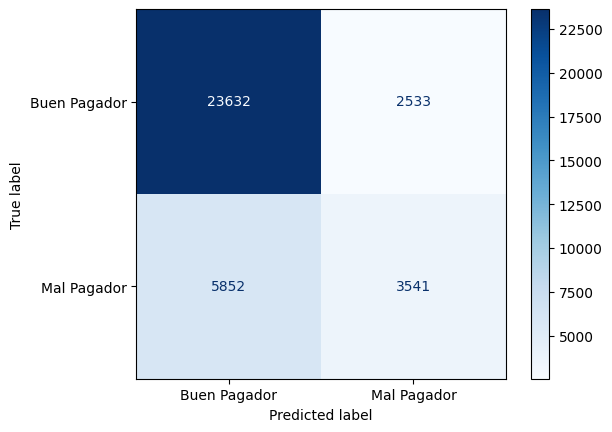

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Usar el modelo entrenado para predecir en los datos de entrenamiento
y_pred = model.predict(X_train)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred, labels=[0, 1])

# Imprimir la matriz de confusión
print('Matriz de Confusión - Edad:')
print(cm)

# Calcular y mostrar el reporte de clasificación
report = classification_report(y_train, y_pred, labels=[0, 1], target_names=['Buen Pagador', 'Mal Pagador'])
print('Reporte de Clasificación:')
print(report)

# Crear y mostrar la matriz de confusión gráficamente
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buen Pagador', 'Mal Pagador'])
cm_display.plot(cmap=plt.cm.Blues)

# Mostrar el gráfico
plt.show()


Regresion logica Numero de dependientes

In [63]:
#Regresion logica dependientes
#definiendo input y output
df['clasificacion_encoded'] = df['clasificacion'].map({'Buen pagador': 0, 'Mal pagador': 1})
X = df[['number_dependents']]  # Puedes cambiar a otra variable como 'edad', 'debt_ratio', etc.
y = df['clasificacion_encoded']

X_train = np.array(df['number_dependents']).reshape(-1, 1)
y_train = np.array(df['clasificacion_encoded'])


In [64]:
# Crear el modelo de regresión logística
model = LogisticRegression()
# Entrenar el modelo
model.fit(X_train, y_train)

LogisticRegression()

In [65]:
#Imprimiendo parametros
print(f"Intercepto (b): {model.intercept_}")
print(f"Intercepto (w): {model.coef_}")

Intercepto (b): [-1.15978285]
Intercepto (w): [[0.17156804]]


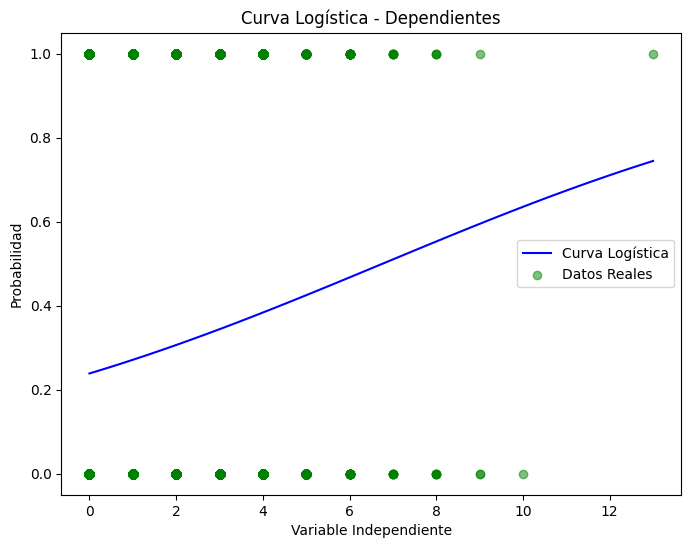

In [66]:
# Crear un rango de valores para la variable independiente
x_values = np.linspace(X.min(), X.max(), 100)

# Calcular las probabilidades predichas
y_prob = model.predict_proba(x_values)[:, 1]

# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar la curva logística
ax.plot(x_values, y_prob, label='Curva Logística', color='blue')

# Graficar los puntos de datos
ax.scatter(X, y, label='Datos Reales', color='green', alpha=0.5)

# Personalizar el gráfico
ax.set_xlabel('Variable Independiente')
ax.set_ylabel('Probabilidad')
ax.set_title('Curva Logística - Dependientes')
ax.legend()

plt.show()

Matriz de Confusión - Dependientes:
[[26151    14]
 [ 9382    11]]
Reporte de Clasificación:
              precision    recall  f1-score   support

Buen Pagador       0.74      1.00      0.85     26165
 Mal Pagador       0.44      0.00      0.00      9393

    accuracy                           0.74     35558
   macro avg       0.59      0.50      0.43     35558
weighted avg       0.66      0.74      0.62     35558



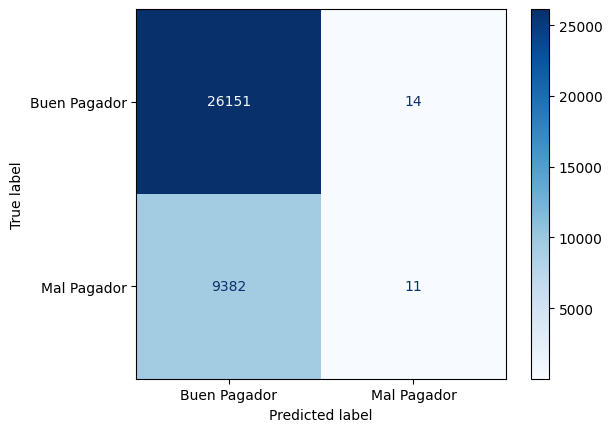

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Usar el modelo entrenado para predecir en los datos de entrenamiento
y_pred = model.predict(X_train)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred, labels=[0, 1])

# Imprimir la matriz de confusión
print('Matriz de Confusión - Dependientes:')
print(cm)

# Calcular y mostrar el reporte de clasificación
report = classification_report(y_train, y_pred, labels=[0, 1], target_names=['Buen Pagador', 'Mal Pagador'])
print('Reporte de Clasificación:')
print(report)

# Crear y mostrar la matriz de confusión gráficamente
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buen Pagador', 'Mal Pagador'])
cm_display.plot(cmap=plt.cm.Blues)

# Mostrar el gráfico
plt.show()


Regresion Logistica more_90_days_overdue

In [68]:
#Regresion logistica mas de 90 dias
#definiendo input y output
df['clasificacion_encoded'] = df['clasificacion'].map({'Buen pagador': 0, 'Mal pagador': 1})
X = df[['more_90_days_overdue']]  # Puedes cambiar a otra variable como 'edad', 'debt_ratio', etc.
y = df['clasificacion_encoded']

X_train = np.array(df['more_90_days_overdue']).reshape(-1, 1)
y_train = np.array(df['clasificacion_encoded'])



In [69]:
# Crear el modelo de regresión logística
model = LogisticRegression()
# Entrenar el modelo
model.fit(X_train, y_train)

LogisticRegression()

In [70]:
#Imprimiendo parametros
print(f"Intercepto (b): {model.intercept_}")
print(f"Intercepto (w): {model.coef_}")

Intercepto (b): [-1.15855932]
Intercepto (w): [[1.70795417]]


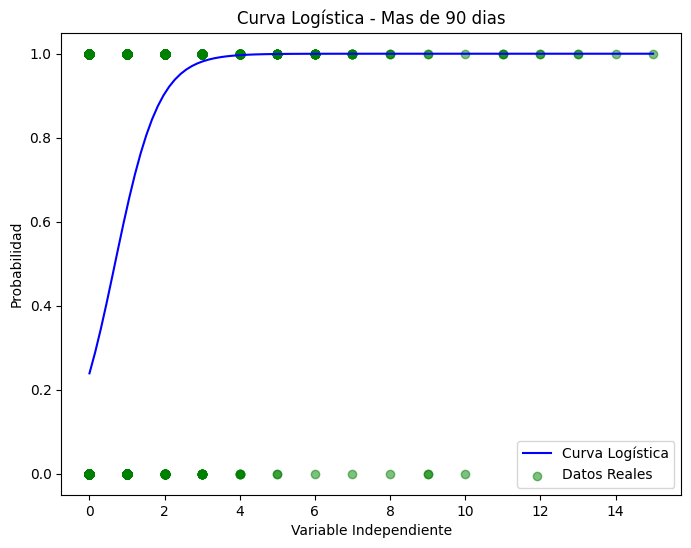

In [71]:
# Crear un rango de valores para la variable independiente
x_values = np.linspace(X.min(), X.max(), 100)

# Calcular las probabilidades predichas
y_prob = model.predict_proba(x_values)[:, 1]

# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar la curva logística
ax.plot(x_values, y_prob, label='Curva Logística', color='blue')

# Graficar los puntos de datos
ax.scatter(X, y, label='Datos Reales', color='green', alpha=0.5)

# Personalizar el gráfico
ax.set_xlabel('Variable Independiente')
ax.set_ylabel('Probabilidad')
ax.set_title('Curva Logística - Mas de 90 dias')
ax.legend()

plt.show()

Matriz de Confusión - Dependientes:
[[25819   346]
 [ 7965  1428]]
Reporte de Clasificación:
              precision    recall  f1-score   support

Buen Pagador       0.76      0.99      0.86     26165
 Mal Pagador       0.80      0.15      0.26      9393

    accuracy                           0.77     35558
   macro avg       0.78      0.57      0.56     35558
weighted avg       0.77      0.77      0.70     35558



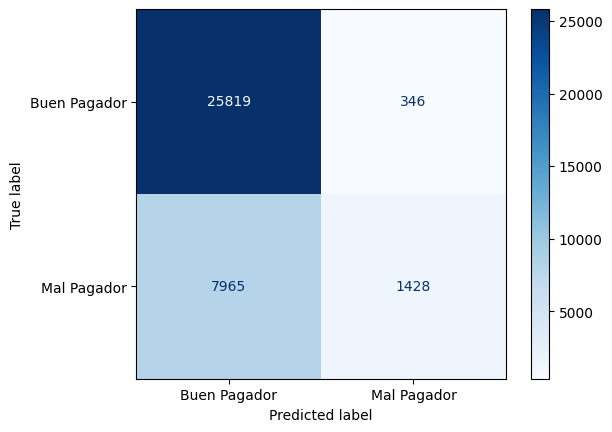

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Usar el modelo entrenado para predecir en los datos de entrenamiento
y_pred = model.predict(X_train)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred, labels=[0, 1])

# Imprimir la matriz de confusión
print('Matriz de Confusión - Dependientes:')
print(cm)

# Calcular y mostrar el reporte de clasificación
report = classification_report(y_train, y_pred, labels=[0, 1], target_names=['Buen Pagador', 'Mal Pagador'])
print('Reporte de Clasificación:')
print(report)

# Crear y mostrar la matriz de confusión gráficamente
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buen Pagador', 'Mal Pagador'])
cm_display.plot(cmap=plt.cm.Blues)

# Mostrar el gráfico
plt.show()

Regresion Logistica Total_ loans

Intercepto (b): [0.21052218]
Intercepto (w): [[-0.16115357]]


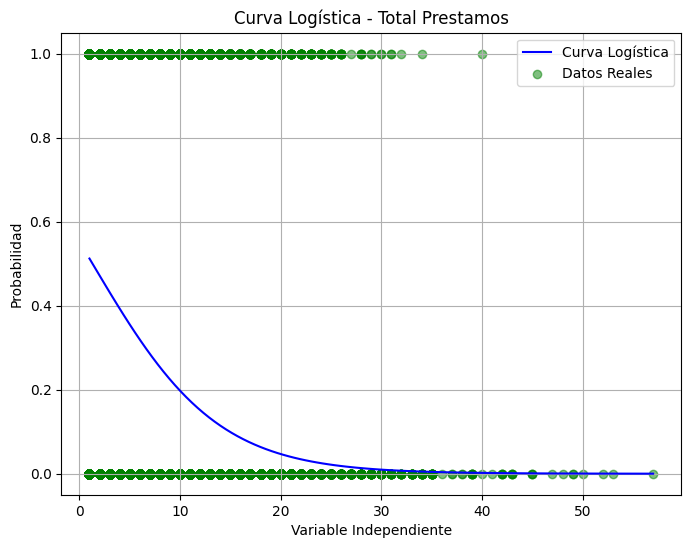

Matriz de Confusión - Total Prestamos:
[[25818   347]
 [ 8676   717]]
Reporte de Clasificación:
              precision    recall  f1-score   support

Buen Pagador       0.75      0.99      0.85     26165
 Mal Pagador       0.67      0.08      0.14      9393

    accuracy                           0.75     35558
   macro avg       0.71      0.53      0.49     35558
weighted avg       0.73      0.75      0.66     35558



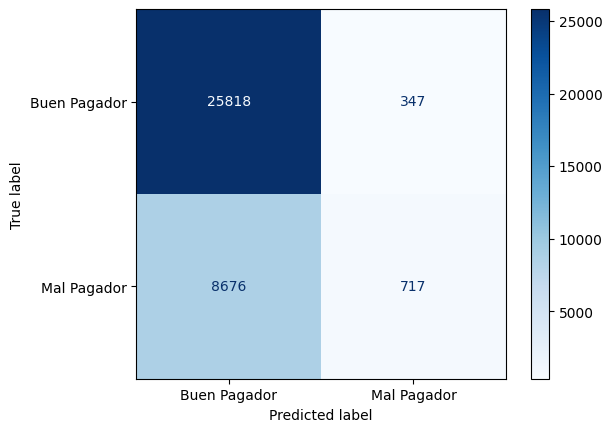

In [73]:
#Regresion logistica total loans
#definiendo input y output
df['clasificacion_encoded'] = df['clasificacion'].map({'Buen pagador': 0, 'Mal pagador': 1})
X = df[['total_loans']]  # Puedes cambiar a otra variable como 'edad', 'debt_ratio', etc.
y = df['clasificacion_encoded']

X_train = np.array(df['total_loans']).reshape(-1, 1)
y_train = np.array(df['clasificacion_encoded'])

# Crear el modelo de regresión logística
model = LogisticRegression()
# Entrenar el modelo
model.fit(X_train, y_train)

#Imprimiendo parametros
print(f"Intercepto (b): {model.intercept_}")
print(f"Intercepto (w): {model.coef_}")

# Crear un rango de valores para la variable independiente
x_values = np.linspace(X.min(), X.max(), 100)

# Calcular las probabilidades predichas
y_prob = model.predict_proba(x_values)[:, 1]

# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar la curva logística
ax.plot(x_values, y_prob, label='Curva Logística', color='blue')

# Graficar los puntos de datos
ax.scatter(X, y, label='Datos Reales', color='green', alpha=0.5)

# Personalizar el gráfico
ax.set_xlabel('Variable Independiente')
ax.set_ylabel('Probabilidad')
ax.set_title('Curva Logística - Total Prestamos')
ax.legend()
plt.grid(True)

plt.show()

#matriz de confusion

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Usar el modelo entrenado para predecir en los datos de entrenamiento
y_pred = model.predict(X_train)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred, labels=[0, 1])

# Imprimir la matriz de confusión
print('Matriz de Confusión - Total Prestamos:')
print(cm)

# Calcular y mostrar el reporte de clasificación
report = classification_report(y_train, y_pred, labels=[0, 1], target_names=['Buen Pagador', 'Mal Pagador'])
print('Reporte de Clasificación:')
print(report)

# Crear y mostrar la matriz de confusión gráficamente
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buen Pagador', 'Mal Pagador'])
cm_display.plot(cmap=plt.cm.Blues)

# Mostrar el gráfico
plt.show()




Regresion Logistica Debt_ratio

Intercepto (b): [-0.88221333]
Intercepto (w): [[-0.00073381]]


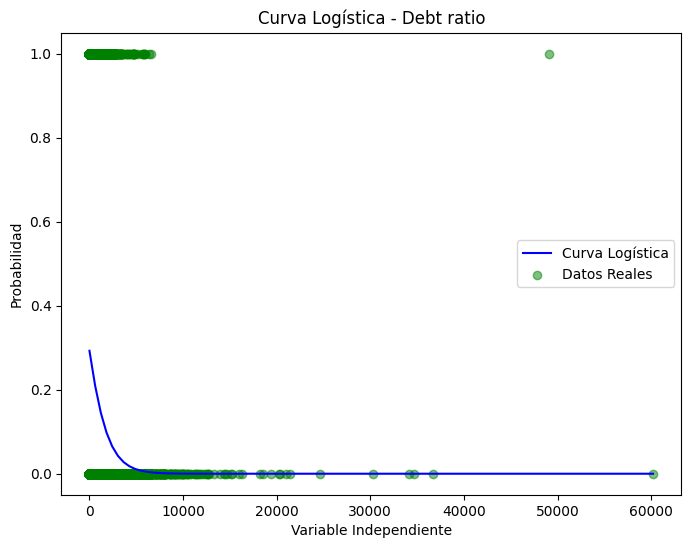

Matriz de Confusión - Debt Ratio:
[[26165     0]
 [ 9393     0]]
Reporte de Clasificación:
              precision    recall  f1-score   support

Buen Pagador       0.74      1.00      0.85     26165
 Mal Pagador       0.00      0.00      0.00      9393

    accuracy                           0.74     35558
   macro avg       0.37      0.50      0.42     35558
weighted avg       0.54      0.74      0.62     35558



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



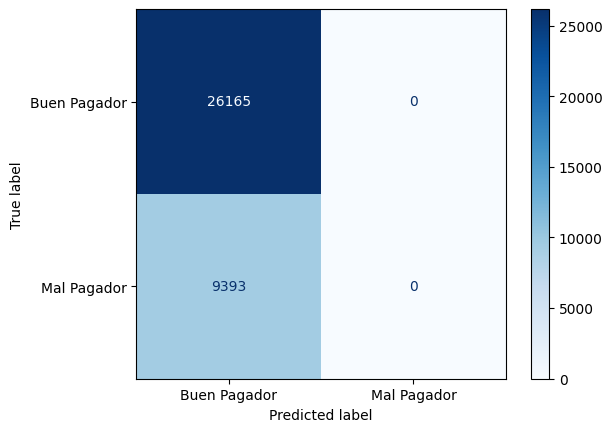

In [74]:
#Regresion logistica debt_ratio
#definiendo input y output
df['clasificacion_encoded'] = df['clasificacion'].map({'Buen pagador': 0, 'Mal pagador': 1})
X = df[['debt_ratio']]  # Puedes cambiar a otra variable como 'edad', 'debt_ratio', etc.
y = df['clasificacion_encoded']

X_train = np.array(df['debt_ratio']).reshape(-1, 1)
y_train = np.array(df['clasificacion_encoded'])

# Crear el modelo de regresión logística
model = LogisticRegression()
# Entrenar el modelo
model.fit(X_train, y_train)

#Imprimiendo parametros
print(f"Intercepto (b): {model.intercept_}")
print(f"Intercepto (w): {model.coef_}")

# Crear un rango de valores para la variable independiente
x_values = np.linspace(X.min(), X.max(), 100)

# Calcular las probabilidades predichas
y_prob = model.predict_proba(x_values)[:, 1]

# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar la curva logística
ax.plot(x_values, y_prob, label='Curva Logística', color='blue')

# Graficar los puntos de datos
ax.scatter(X, y, label='Datos Reales', color='green', alpha=0.5)

# Personalizar el gráfico
ax.set_xlabel('Variable Independiente')
ax.set_ylabel('Probabilidad')
ax.set_title('Curva Logística - Debt ratio')
ax.legend()

plt.show()

#matriz de confusion

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Usar el modelo entrenado para predecir en los datos de entrenamiento
y_pred = model.predict(X_train)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred, labels=[0, 1])

# Imprimir la matriz de confusión
print('Matriz de Confusión - Debt Ratio:')
print(cm)

# Calcular y mostrar el reporte de clasificación
report = classification_report(y_train, y_pred, labels=[0, 1], target_names=['Buen Pagador', 'Mal Pagador'])
print('Reporte de Clasificación:')
print(report)

# Crear y mostrar la matriz de confusión gráficamente
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buen Pagador', 'Mal Pagador'])
cm_display.plot(cmap=plt.cm.Blues)

# Mostrar el gráfico
plt.show()



Regresion logistica using_lines_not_secured_personal_assets


Intercepto (b): [-1.02585147]
Intercepto (w): [[0.00022335]]


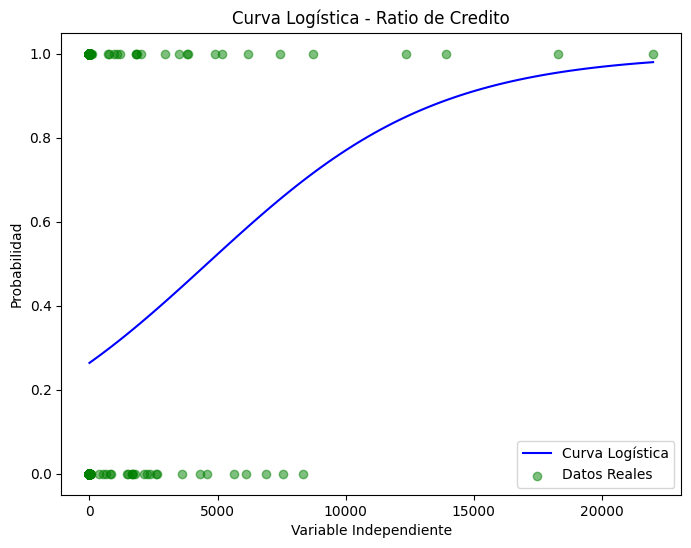

Matriz de Confusión - Ratio de credito:
[[26160     5]
 [ 9384     9]]
Reporte de Clasificación:
              precision    recall  f1-score   support

Buen Pagador       0.74      1.00      0.85     26165
 Mal Pagador       0.64      0.00      0.00      9393

    accuracy                           0.74     35558
   macro avg       0.69      0.50      0.42     35558
weighted avg       0.71      0.74      0.62     35558



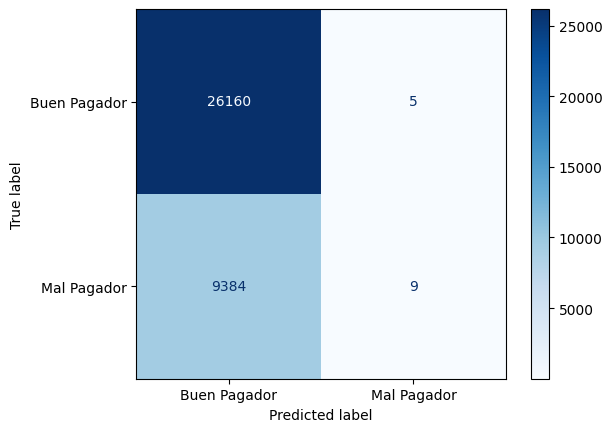

In [75]:
#Regresion logistica Ratio de credito
#definiendo input y output
df['clasificacion_encoded'] = df['clasificacion'].map({'Buen pagador': 0, 'Mal pagador': 1})
X = df[['using_lines_not_secured_personal_assets']]  # Puedes cambiar a otra variable como 'edad', 'debt_ratio', etc.
y = df['clasificacion_encoded']

X_train = np.array(df['using_lines_not_secured_personal_assets']).reshape(-1, 1)
y_train = np.array(df['clasificacion_encoded'])

# Crear el modelo de regresión logística
model = LogisticRegression()
# Entrenar el modelo
model.fit(X_train, y_train)

#Imprimiendo parametros
print(f"Intercepto (b): {model.intercept_}")
print(f"Intercepto (w): {model.coef_}")

# Crear un rango de valores para la variable independiente
x_values = np.linspace(X.min(), X.max(), 100)

# Calcular las probabilidades predichas
y_prob = model.predict_proba(x_values)[:, 1]

# Crear la figura y los ejes para el gráfico
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar la curva logística
ax.plot(x_values, y_prob, label='Curva Logística', color='blue')

# Graficar los puntos de datos
ax.scatter(X, y, label='Datos Reales', color='green', alpha=0.5)

# Personalizar el gráfico
ax.set_xlabel('Variable Independiente')
ax.set_ylabel('Probabilidad')
ax.set_title('Curva Logística - Ratio de Credito')
ax.legend()

plt.show()

#matriz de confusion

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Usar el modelo entrenado para predecir en los datos de entrenamiento
y_pred = model.predict(X_train)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred, labels=[0, 1])

# Imprimir la matriz de confusión
print('Matriz de Confusión - Ratio de credito:')
print(cm)

# Calcular y mostrar el reporte de clasificación
report = classification_report(y_train, y_pred, labels=[0, 1], target_names=['Buen Pagador', 'Mal Pagador'])
print('Reporte de Clasificación:')
print(report)

# Crear y mostrar la matriz de confusión gráficamente
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buen Pagador', 'Mal Pagador'])
cm_display.plot(cmap=plt.cm.Blues)

# Mostrar el gráfico
plt.show()

